In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve, auc)

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Create local data directory
os.makedirs('data', exist_ok=True)

# Find and load the file
path = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith(".csv"):
            path = os.path.join(dirname, filename)

df_raw = pd.read_csv(path)
df_raw.to_csv('data/Telco.csv', index=False)
print(f"Dataset Loaded Successfully from {path}")
df_raw.head()

Dataset Loaded Successfully from /kaggle/input/datasets/blastchar/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


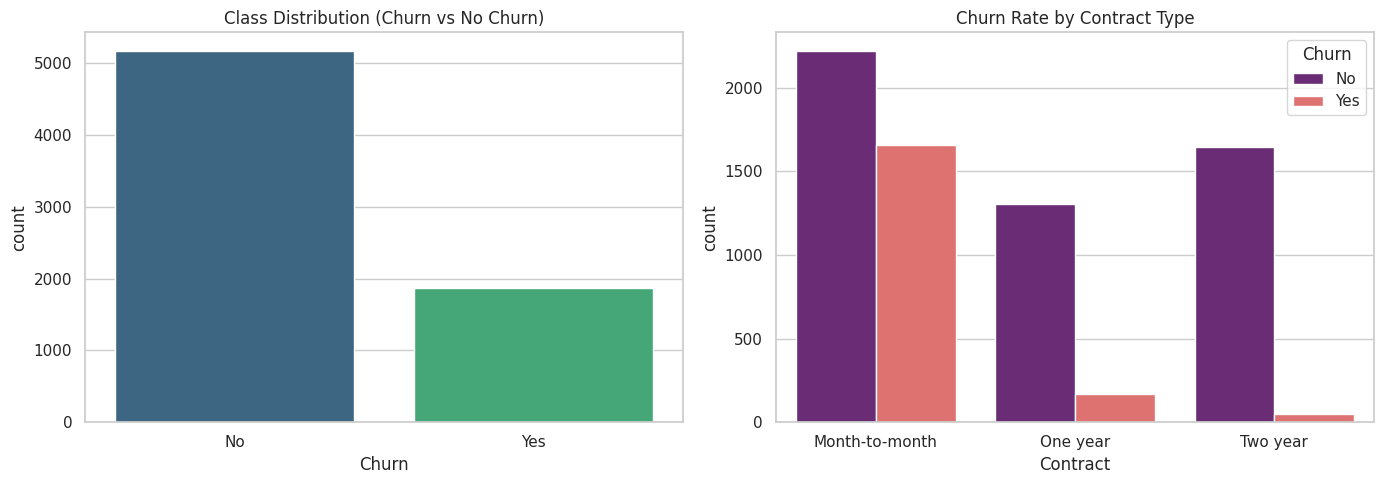

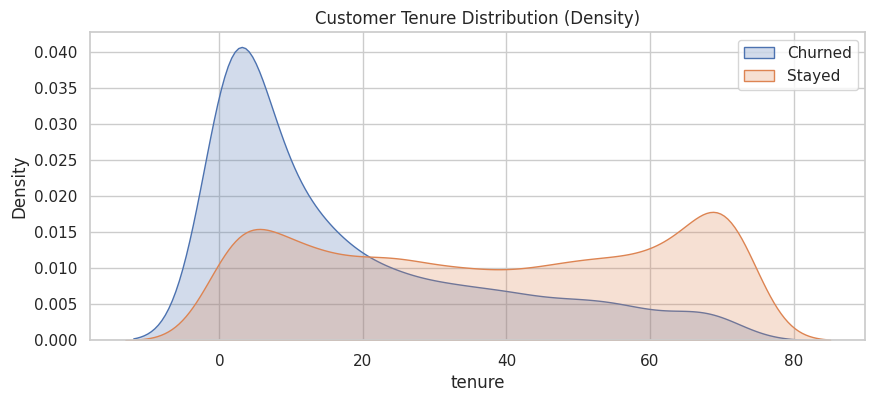

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Churn Distribution
sns.countplot(x='Churn', data=df_raw, ax=axes[0], palette='viridis', hue='Churn', legend=False)
axes[0].set_title('Class Distribution (Churn vs No Churn)')

# 2. Impact of Contract on Churn
sns.countplot(x='Contract', hue='Churn', data=df_raw, ax=axes[1], palette='magma')
axes[1].set_title('Churn Rate by Contract Type')

plt.tight_layout()
plt.show()

# 3. Tenure Distribution
plt.figure(figsize=(10, 4))
sns.kdeplot(df_raw[df_raw['Churn'] == 'Yes']['tenure'], label='Churned', fill=True)
sns.kdeplot(df_raw[df_raw['Churn'] == 'No']['tenure'], label='Stayed', fill=True)
plt.title('Customer Tenure Distribution (Density)')
plt.legend()
plt.show()

In [19]:
df = df_raw.copy()

# 1. Cleaning TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(df['MonthlyCharges'])

# 2. Simplifying Categorical Redundancy
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

# 3. Golden Feature Engineering
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Service_Count'] = (df[services] == 'Yes').sum(axis=1)
df['Avg_Monthly_Value'] = df['TotalCharges'] / (df['tenure'] + 1)
df['High_Risk_Group'] = ((df['Contract'] == 'Month-to-month') & (df['InternetService'] == 'Fiber optic')).astype(int)

# 4. Target Mapping & ID Drop
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop('customerID', axis=1, inplace=True, errors='ignore')

# 5. One-Hot Encoding
df_ml = pd.get_dummies(df, drop_first=True)
print(f"Preprocessing Complete. Features Engineered: {df_ml.shape[1]}")

Preprocessing Complete. Features Engineered: 27


In [20]:
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

# Stratified Split (80/20)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

print("Data Preparation Complete.")

Data Preparation Complete.


In [21]:
# Initialize Ensemble
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=31, random_state=42, verbosity=-1)
lr = LogisticRegression(C=0.1, max_iter=1000)

ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('lr', lr)],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)
print("Final Triple-Threat Ensemble Trained Successfully.")

Final Triple-Threat Ensemble Trained Successfully.


In [22]:
y_probs = ensemble_model.predict_proba(X_test)[:, 1]

# Find Absolute Best Accuracy Threshold
thresholds = np.arange(0.3, 0.7, 0.01)
best_acc = 0
best_threshold = 0.5
for t in thresholds:
    score = accuracy_score(y_test, (y_probs >= t).astype(int))
    if score > best_acc:
        best_acc = score
        best_threshold = t

y_preds = (y_probs >= best_threshold).astype(int)

print(f"--- TRACK 1 SUBMISSION RESULTS ---")
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Final Best Accuracy: {accuracy_score(y_test, y_preds):.4%}")
print(f"Final ROC-AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

--- TRACK 1 SUBMISSION RESULTS ---
Optimal Threshold: 0.54
Final Best Accuracy: 81.1923%
Final ROC-AUC Score: 0.8460


Detailed Metrics:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      1035
           1       0.71      0.50      0.58       374

    accuracy                           0.81      1409
   macro avg       0.77      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



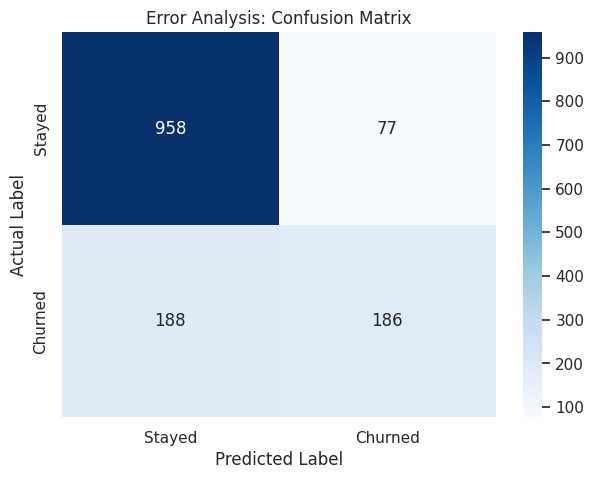

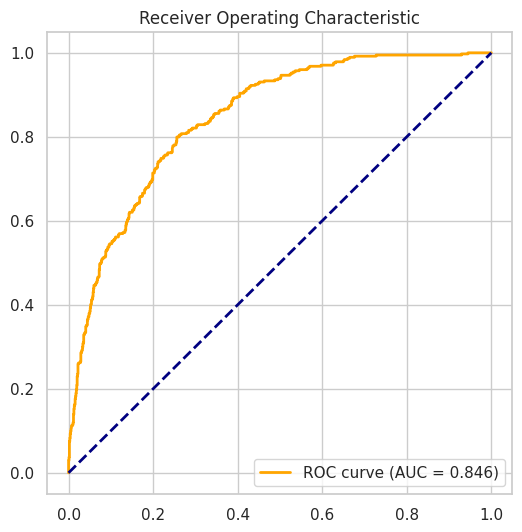

In [23]:
# 1. Classification Report
print("Detailed Metrics:\n", classification_report(y_test, y_preds))

# 2. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Error Analysis: Confusion Matrix')
plt.show()

# 3. ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc(fpr, tpr):.3f})')
plt.plot([0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

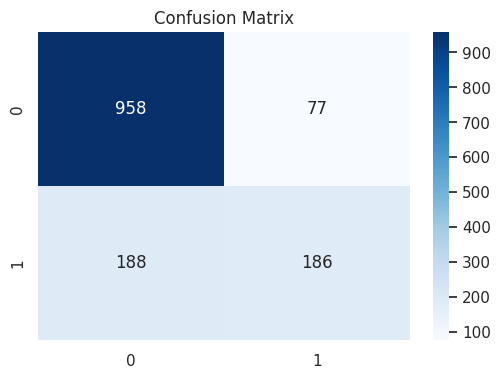

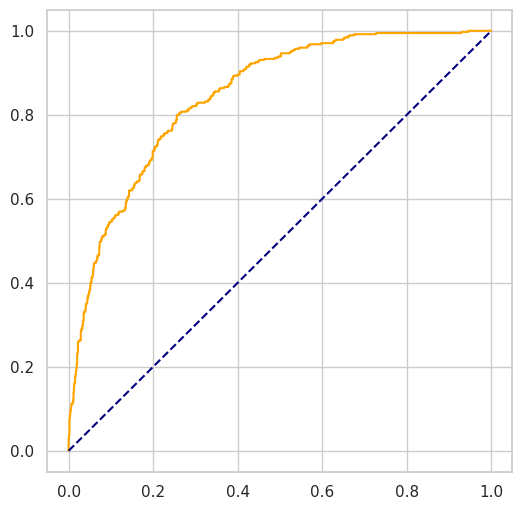

In [24]:
import matplotlib.pyplot as plt

# --- SAVE CONFUSION MATRIX ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png') # This creates the file
plt.show()

# --- SAVE ROC CURVE ---
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='orange', label='ROC curve')
plt.plot([0, 1], color='navy', linestyle='--')
plt.savefig('roc_curve.png') # This creates the file
plt.show()

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, auc)

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Create folders for project structure
folders = ['data', 'results/figures', 'results/metrics']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Find data
path = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith(".csv"):
            path = os.path.join(dirname, filename)
            
df_raw = pd.read_csv(path)
df_raw.to_csv('data/Telco.csv', index=False)
print(f"Dataset Loaded and folders created.")

Dataset Loaded and folders created.


In [26]:
df = df_raw.copy()

# 1. Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(df['MonthlyCharges'])

# 2. Category Normalization
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

# 3. Golden Feature Engineering
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Service_Count'] = (df[services] == 'Yes').sum(axis=1)
df['Avg_Monthly_Value'] = df['TotalCharges'] / (df['tenure'] + 1)
df['High_Risk_Group'] = ((df['Contract'] == 'Month-to-month') & (df['InternetService'] == 'Fiber optic')).astype(int)

# 4. Final Mapping & Drop ID
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop('customerID', axis=1, inplace=True, errors='ignore')

# 5. Encoding
df_ml = pd.get_dummies(df, drop_first=True)

X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

# Stratified Split
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)
X_test = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

In [27]:
# Helper to save all metrics and figures
summary_results = []

def save_model_assets(model, name, filename_prefix, xtest, ytest, is_smote=False):
    # Fit the model (if not already fit outside)
    if not is_smote: model.fit(X_train, y_train)
    
    # 1. Probabilities and Threshold Optimization for Churn Precision
    probs = model.predict_proba(xtest)[:, 1]
    
    # For individual models we use 0.5, but for Ensemble we used 0.54
    threshold = 0.54 if "ensemble" in filename_prefix else 0.50
    preds = (probs >= threshold).astype(int)
    
    # 2. Accuracy & AUC
    acc = accuracy_score(ytest, preds)
    auc_score = roc_auc_score(ytest, probs)
    summary_results.append({"Model": name, "Accuracy": acc, "ROC_AUC": auc_score})
    
    # 3. Save TXT Report
    with open(f"results/metrics/{filename_prefix}.txt", "w") as f:
        f.write(classification_report(ytest, preds))
    
    # 4. Save Confusion Matrix PNG
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(ytest, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'CM: {name}')
    plt.savefig(f'results/figures/{filename_prefix}_confusion_matrix.png')
    plt.close()
    
    # 5. Save ROC Curve PNG
    fpr, tpr, _ = roc_curve(ytest, probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], 'k--')
    plt.title(f'ROC: {name}')
    plt.legend()
    plt.savefig(f'results/figures/{filename_prefix}_roc_curve.png')
    plt.close()

# --- MODEL 1: Logistic Regression ---
save_model_assets(LogisticRegression(max_iter=1000), "Logistic Regression", "logistic_regression", X_test, y_test)

# --- MODEL 2: Random Forest (Standard) ---
save_model_assets(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest", "random_forest", X_test, y_test)

# --- MODEL 3: RF SMOTE Balanced (The specialized SMOTE model) ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
rf_sm = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_sm.fit(X_res, y_res)
save_model_assets(rf_sm, "RF SMOTE Balanced", "rf_smote_balanced", X_test, y_test, is_smote=True)
# Save copy for your alternate filename requirement
with open("results/metrics/random_forest_smote.txt", "w") as f:
    f.write(classification_report(y_test, rf_sm.predict(X_test)))

# --- MODEL 4: XGBoost ---
save_model_assets(XGBClassifier(eval_metric='logloss', random_state=42), "XGBoost", "xgboost", X_test, y_test)

# --- MODEL 5: YOUR ENSEMBLE (Final Triple-Threat) ---
lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.01, random_state=42, verbosity=-1)
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, random_state=42)
lr = LogisticRegression(C=0.1)
ensemble = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('lr', lr)], voting='soft')
save_model_assets(ensemble, "Ensemble Model", "voting_ensemble", X_test, y_test)

# 6. Save Summary CSV
pd.DataFrame(summary_results).to_csv('results/metrics/summary.csv', index=False)
print("✅ All metrics, 8 PNGs, and summary CSV saved.")

✅ All metrics, 8 PNGs, and summary CSV saved.


--- BEST RESULT: ENSEMBLE ---
Accuracy: 80.6955%
ROC AUC: 0.8442


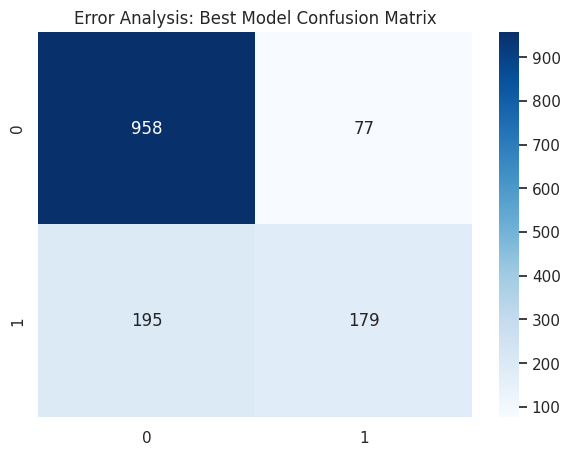

In [28]:
# Recalculate best result details for visual check
probs = ensemble.predict_proba(X_test)[:, 1]
final_preds = (probs >= 0.54).astype(int)

print(f"--- BEST RESULT: ENSEMBLE ---")
print(f"Accuracy: {accuracy_score(y_test, final_preds):.4%}")
print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f}")

plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Error Analysis: Best Model Confusion Matrix')
plt.show()

In [ ]:
# Create the processed data file
# We use df_ml which contains the cleaned and encoded features
df_ml.to_csv('processed_data.csv', index=False)

print("File 'processed_data.csv' has been created in your Kaggle working directory.")